In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [2]:
import os
from pyspark.sql import SparkSession

local_jar = os.path.abspath("jars/postgresql-42.7.7.jar")

spark = SparkSession.builder \
    .appName("MSSQL_to_Postgres") \
    .config("spark.jars.packages", "com.microsoft.sqlserver:mssql-jdbc:12.6.1.jre11") \
    .config("spark.jars", local_jar) \
    .getOrCreate()

jdbc_url = "jdbc:sqlserver://localhost:1433;databaseName=AdventureWorksDB;encrypt=false;trustServerCertificate=true"
properties = {
    "user": "SA",
    "password": "admin@123",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

# Step 1: get list of tables from SQL Server
tables_df = spark.read.jdbc(
    url=jdbc_url,
    table="(SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE='BASE TABLE' AND TABLE_SCHEMA='Sales') AS t",
    properties=properties
)

tables = [(row.TABLE_NAME) for row in tables_df.collect()]

# Step 2: loop and load each table
dfs = {}
for table in tables:
    full_table = f"Sales.{table}"
    print(f"Loading {full_table} ...")
    df = spark.read.jdbc(url=jdbc_url, table=full_table, properties=properties)
    dfs[full_table] = df

# Example: show Sales.PersonPhone
dfs["Sales.Customer"].show(5)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/24 08:42:09 WARN Utils: Your hostname, nqh, resolves to a loopback address: 127.0.1.1; using 192.168.1.46 instead (on interface wlp2s0)
25/09/24 08:42:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/hwnglk25/hwnglk25/hit_training/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/hwnglk25/.ivy2.5.2/cache
The jars for the packages stored in: /home/hwnglk25/.ivy2.5.2/jars
com.microsoft.sqlserver#mssql-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2702747a-d71b-4429-9b71-c7c33f598f65;1.0
	confs: [default]
	found com.microsoft.sqlserver#mssql-jdbc;12.6.1.jre11 in central
:: resolution report :: resolve 203ms :: artifacts dl 6ms
	:: modules in use:
	com.microsoft.sqlserver#mssql-jdbc;12.6.1.jre11 from cen

Loading Sales.SalesTaxRate ...
Loading Sales.PersonCreditCard ...
Loading Sales.SalesTerritory ...
Loading Sales.SalesTerritoryHistory ...
Loading Sales.ShoppingCartItem ...
Loading Sales.SpecialOffer ...
Loading Sales.SpecialOfferProduct ...
Loading Sales.Store ...
Loading Sales.CountryRegionCurrency ...
Loading Sales.CreditCard ...
Loading Sales.Currency ...
Loading Sales.CurrencyRate ...
Loading Sales.Customer ...
Loading Sales.SalesOrderDetail ...
Loading Sales.SalesOrderHeader ...
Loading Sales.SalesOrderHeaderSalesReason ...
Loading Sales.SalesPerson ...
Loading Sales.SalesPersonQuotaHistory ...
Loading Sales.SalesReason ...
+----------+--------+-------+-----------+-------------+--------------------+--------------------+
|CustomerID|PersonID|StoreID|TerritoryID|AccountNumber|             rowguid|        ModifiedDate|
+----------+--------+-------+-----------+-------------+--------------------+--------------------+
|         1|    NULL|    934|          1|   AW00000001|3F5AE95E-B87

In [3]:
tables = ["Sales.SpecialOffer", "Sales.SpecialOfferProduct", "Sales.SalesPerson",
          "Sales.SalesTerritory", "Sales.CurrencyRate", 
          "Sales.SalesOrderHeader", "Sales.SalesOrderDetail", 
          "Sales.SalesPersonQuotaHistory"]

new_df = {name: dfs[name] for name in tables}


In [4]:
for table_name, df in new_df.items():
    print(f"Table: {table_name}")
    print("Row count:", df.count())
    print("Column count:", len(df.columns))
    df.printSchema()


Table: Sales.SpecialOffer
Row count: 16
Column count: 11
root
 |-- SpecialOfferID: integer (nullable = true)
 |-- Description: string (nullable = true)
 |-- DiscountPct: decimal(10,4) (nullable = true)
 |-- Type: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- StartDate: timestamp (nullable = true)
 |-- EndDate: timestamp (nullable = true)
 |-- MinQty: integer (nullable = true)
 |-- MaxQty: integer (nullable = true)
 |-- rowguid: string (nullable = true)
 |-- ModifiedDate: timestamp (nullable = true)

Table: Sales.SpecialOfferProduct
Row count: 538
Column count: 4
root
 |-- SpecialOfferID: integer (nullable = true)
 |-- ProductID: integer (nullable = true)
 |-- rowguid: string (nullable = true)
 |-- ModifiedDate: timestamp (nullable = true)

Table: Sales.SalesPerson
Row count: 17
Column count: 9
root
 |-- BusinessEntityID: integer (nullable = true)
 |-- TerritoryID: integer (nullable = true)
 |-- SalesQuota: decimal(19,4) (nullable = true)
 |-- Bonus: decimal(19,4

In [5]:
for table_name, df in new_df.items():
    print(f"\nSummary statistics for {table_name}:")
    df.describe().show()



Summary statistics for Sales.SpecialOffer:


25/09/24 08:42:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+------------------+--------------------+--------+------------------+-----------------+--------------------+
|summary|   SpecialOfferID|         Description|       DiscountPct|                Type|Category|            MinQty|           MaxQty|             rowguid|
+-------+-----------------+--------------------+------------------+--------------------+--------+------------------+-----------------+--------------------+
|  count|               16|                  16|                16|                  16|      16|                16|                4|                  16|
|   mean|              8.5|                NULL|        0.22000000|                NULL|    NULL|            9.5625|             34.5|                NULL|
| stddev|4.760952285695233|                NULL|0.1614517471774978|                NULL|    NULL|18.092240509861313|20.09145755455952|                NULL|
|    min|                1|Half-Price Pedal ...|            0.00

+-------+-----------------+--------------------+------+----------------+-------------------+--------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------------+-----------------+-----------------+------------------+-----------------+------------------+-------+--------------------+
|summary|     SalesOrderID|      RevisionNumber|Status|SalesOrderNumber|PurchaseOrderNumber| AccountNumber|       CustomerID|    SalesPersonID|      TerritoryID|   BillToAddressID|   ShipToAddressID|      ShipMethodID|     CreditCardID|CreditCardApprovalCode|   CurrencyRateID|         SubTotal|            TaxAmt|          Freight|          TotalDue|Comment|             rowguid|
+-------+-----------------+--------------------+------+----------------+-------------------+--------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+--

+-------+------------------+------------------+---------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+--------------------+
|summary|      SalesOrderID|SalesOrderDetailID|CarrierTrackingNumber|          OrderQty|        ProductID|    SpecialOfferID|        UnitPrice|  UnitPriceDiscount|         LineTotal|             rowguid|
+-------+------------------+------------------+---------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+--------------------+
|  count|            121317|            121317|                60919|            121317|           121317|            121317|           121317|             121317|            121317|              121317|
|   mean|57827.363782487206|           60659.0|                 NULL|2.2660797744751355|841.6808361565156|1.1625411113034447|     465.09349567|         0.00282607|    905.4492066230|  

In [6]:
from pyspark.sql import functions as F

for table_name, df in new_df.items():
    print(f"\n===Not Null counts for {table_name} ===")
    null_counts = df.select([
        F.count(F.when(F.col(c).isNotNull(), c)).alias(c + "_nulls")
        for c in df.columns
    ])
    null_counts.show(truncate=False)



===Not Null counts for Sales.SpecialOffer ===
+--------------------+-----------------+-----------------+----------+--------------+---------------+-------------+------------+------------+-------------+------------------+
|SpecialOfferID_nulls|Description_nulls|DiscountPct_nulls|Type_nulls|Category_nulls|StartDate_nulls|EndDate_nulls|MinQty_nulls|MaxQty_nulls|rowguid_nulls|ModifiedDate_nulls|
+--------------------+-----------------+-----------------+----------+--------------+---------------+-------------+------------+------------+-------------+------------------+
|16                  |16               |16               |16        |16            |16             |16           |16          |4           |16           |16                |
+--------------------+-----------------+-----------------+----------+--------------+---------------+-------------+------------+------------+-------------+------------------+


===Not Null counts for Sales.SpecialOfferProduct ===
+--------------------+------

In [7]:
for table_name, df in new_df.items():
    print(f"\n===Null percentage for {table_name} ===")
    total_rows = df.count()
    null_perc = df.select([
        (F.count(F.when(F.col(c).isNull(), c)) / total_rows * 100).alias(c+"_null_%")
        for c in df.columns
    ])
    null_perc.show(truncate=False)


===Null percentage for Sales.SpecialOffer ===
+---------------------+------------------+------------------+-----------+---------------+----------------+--------------+-------------+-------------+--------------+-------------------+
|SpecialOfferID_null_%|Description_null_%|DiscountPct_null_%|Type_null_%|Category_null_%|StartDate_null_%|EndDate_null_%|MinQty_null_%|MaxQty_null_%|rowguid_null_%|ModifiedDate_null_%|
+---------------------+------------------+------------------+-----------+---------------+----------------+--------------+-------------+-------------+--------------+-------------------+
|0.0                  |0.0               |0.0               |0.0        |0.0            |0.0             |0.0           |0.0          |75.0         |0.0           |0.0                |
+---------------------+------------------+------------------+-----------+---------------+----------------+--------------+-------------+-------------+--------------+-------------------+


===Null percentage for Sal

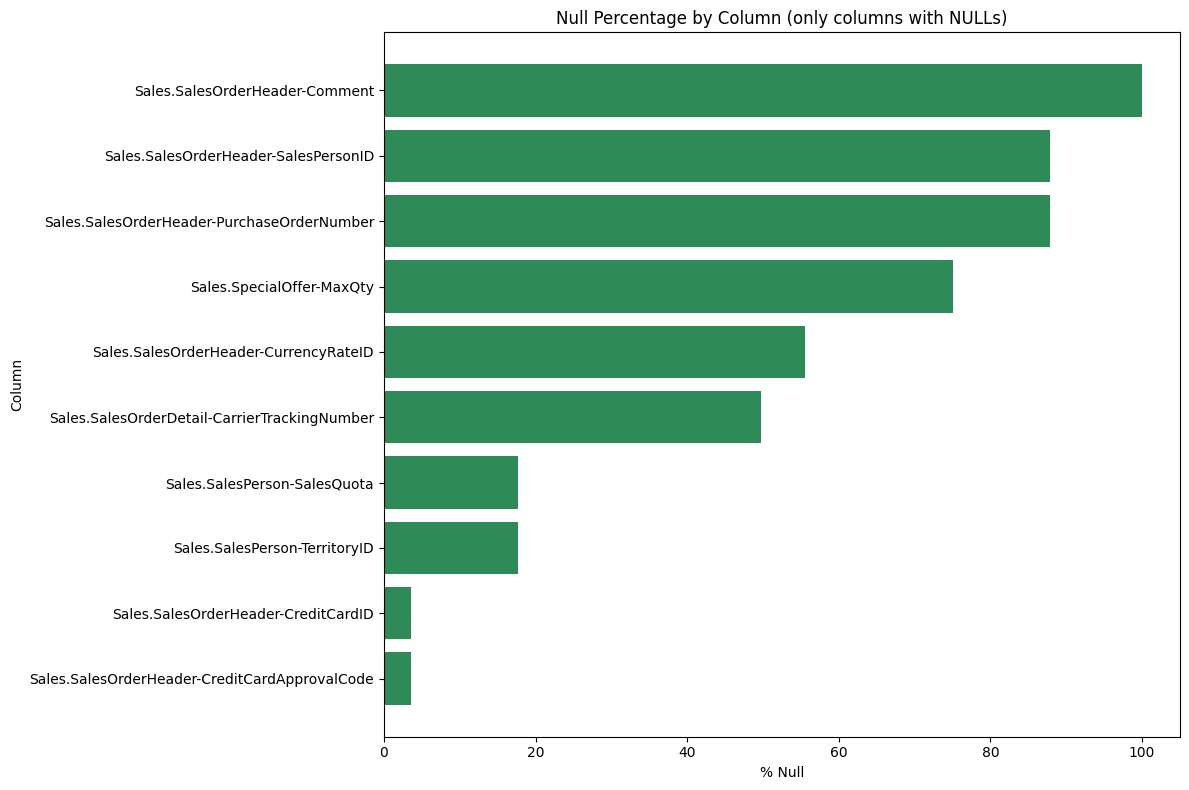

In [8]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pandas as pd

null_info = []

for table_name, df in new_df.items():
    total_rows = df.count()

    null_perc_df = df.select([
        (F.count(F.when(F.col(c).isNull(), c)) / total_rows * 100).alias(c)
        for c in df.columns
    ])
    pdf = null_perc_df.toPandas()

    pdf_t = pdf.T.reset_index()
    pdf_t.columns = ["column", "null_percentage"]

    pdf_t = pdf_t[pdf_t["null_percentage"] > 0]

    pdf_t["column"] = pdf_t["column"].apply(lambda x: f"{table_name}-{x}")

    null_info.append(pdf_t)

all_nulls = pd.concat(null_info, ignore_index=True)

all_nulls = all_nulls.sort_values("null_percentage", ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(all_nulls["column"], all_nulls["null_percentage"], color="seagreen")
plt.xlabel("% Null")
plt.ylabel("Column")
plt.title("Null Percentage by Column (only columns with NULLs)")
plt.tight_layout()
plt.show()


 - Sales.SalesOrderHeader - Comment: order notes  
   - Can be null because many orders do not include extra comments  
 - Sales.SalesOrderHeader - SalesPersonID: salesperson responsible for the order  
   - Can be null because some orders are placed online or without an assigned salesperson  
 - Sales.SalesOrderHeader - PurchaseOrderNumber: customer’s purchase order number  
   - Can be null because not all customers provide a purchase order number, especially retail customers  
 - Sales.SalesOrderHeader - CreditCardID: credit card information  
   - Can be null because not all orders are paid by credit card; some use other payment methods  
 - Sales.SalesOrderHeader - CreditCardApprovalCode: credit card approval information  
   - Can be null because it only applies when the payment is made by credit card  
 - Sales.SpecialOffer - MaxQty: maximum quantity eligible for the offer  
   - Can be null because some special offers may not have a maximum quantity restriction  
 - Sales.SalesOrderDetail - CarrierTrackingNumber: shipment tracking number  
 - Sales.SalesPerson - SalesQuota: sales target for the salesperson  
 - Sales.SalesPerson - TerritoryID: sales territory assigned to the salesperson  


## Question 1: Is the revenue on days with campaigns or promotional programs higher than on other days?

Table use:
 - SalesOrderHeader
 - SalesOrderDetail

In [9]:
tables = ["Sales.SalesOrderHeader", "Sales.SalesOrderDetail"]

Q1_df = {name: new_df[name] for name in tables}


In [10]:

for table_name, df in Q1_df.items():
    print(f"\n===Null percentage for {table_name} ===")
    total_rows = df.count()
    null_perc = df.select([
        (F.count(F.when(F.col(c).isNull(), c)) / total_rows * 100).alias(c+"_null_%")
        for c in df.columns
    ])
    null_perc.show(truncate=False)


===Null percentage for Sales.SalesOrderHeader ===
+-------------------+---------------------+----------------+--------------+---------------+-------------+----------------------+-----------------------+--------------------------+--------------------+-----------------+--------------------+------------------+----------------------+----------------------+-------------------+-------------------+-----------------------------+---------------------+---------------+-------------+--------------+---------------+--------------+--------------+-------------------+
|SalesOrderID_null_%|RevisionNumber_null_%|OrderDate_null_%|DueDate_null_%|ShipDate_null_%|Status_null_%|OnlineOrderFlag_null_%|SalesOrderNumber_null_%|PurchaseOrderNumber_null_%|AccountNumber_null_%|CustomerID_null_%|SalesPersonID_null_%|TerritoryID_null_%|BillToAddressID_null_%|ShipToAddressID_null_%|ShipMethodID_null_%|CreditCardID_null_%|CreditCardApprovalCode_null_%|CurrencyRateID_null_%|SubTotal_null_%|TaxAmt_null_%|Freight_null_%|

In [22]:
header_df = Q1_df["Sales.SalesOrderHeader"]
header_check = header_df.select("SalesOrderID", "OrderDate")
header_check.printSchema()
header_check.show(10, truncate=False)


root
 |-- SalesOrderID: integer (nullable = true)
 |-- OrderDate: timestamp (nullable = true)

+------------+-------------------+
|SalesOrderID|OrderDate          |
+------------+-------------------+
|43659       |2011-05-31 00:00:00|
|43660       |2011-05-31 00:00:00|
|43661       |2011-05-31 00:00:00|
|43662       |2011-05-31 00:00:00|
|43663       |2011-05-31 00:00:00|
|43664       |2011-05-31 00:00:00|
|43665       |2011-05-31 00:00:00|
|43666       |2011-05-31 00:00:00|
|43667       |2011-05-31 00:00:00|
|43668       |2011-05-31 00:00:00|
+------------+-------------------+
only showing top 10 rows


In [23]:
detail_df = Q1_df["Sales.SalesOrderDetail"]
detail_check = detail_df.select("SalesOrderID", "SpecialOfferID", "LineTotal")
detail_check.printSchema()
detail_check.show(10, truncate=False)

detail_check.describe(["LineTotal"]).show()


detail_check.groupBy("SpecialOfferID").count().orderBy("count", ascending=False).show()


root
 |-- SalesOrderID: integer (nullable = true)
 |-- SpecialOfferID: integer (nullable = true)
 |-- LineTotal: decimal(38,6) (nullable = true)

+------------+--------------+-----------+
|SalesOrderID|SpecialOfferID|LineTotal  |
+------------+--------------+-----------+
|43659       |1             |2024.994000|
|43659       |1             |6074.982000|
|43659       |1             |2024.994000|
|43659       |1             |2039.994000|
|43659       |1             |2039.994000|
|43659       |1             |4079.988000|
|43659       |1             |2039.994000|
|43659       |1             |86.521200  |
|43659       |1             |28.840400  |
|43659       |1             |34.200000  |
+------------+--------------+-----------+
only showing top 10 rows
+-------+------------------+
|summary|         LineTotal|
+-------+------------------+
|  count|            121317|
|   mean|    905.4492066230|
| stddev|1693.4173889709273|
|    min|          1.374000|
|    max|      27893.619000|
+-------+

In [11]:
from pyspark.sql import functions as F

df = (Q1_df["Sales.SalesOrderHeader"]
      .join(Q1_df["Sales.SalesOrderDetail"], "SalesOrderID"))

df = df.withColumn("OrderDate", F.to_date("OrderDate"))

result = (df.groupBy("OrderDate")
            .agg(
                F.sum("LineTotal").alias("TotalRevenue"),
                F.max(F.when(F.col("SpecialOfferID") != 1, 1).otherwise(0)).alias("HasPromo")
            )
            .withColumn("PromoFlag", F.when(F.col("HasPromo") == 1, "Promo").otherwise("No Promo"))
            .drop("HasPromo")
            .orderBy("TotalRevenue", ascending=False))

result.show(1000, truncate=False)


+----------+--------------+---------+
|OrderDate |TotalRevenue  |PromoFlag|
+----------+--------------+---------+
|2013-06-30|4243372.781596|Promo    |
|2013-07-31|4071385.007794|Promo    |
|2012-06-30|3617451.922751|Promo    |
|2013-10-30|3574272.949802|Promo    |
|2013-09-30|3514278.305303|Promo    |
|2014-05-01|3460129.769338|Promo    |
|2014-03-31|3396947.599904|Promo    |
|2012-09-30|3064632.130985|Promo    |
|2013-03-30|2902832.685835|Promo    |
|2012-07-31|2888213.608371|Promo    |
|2014-01-29|2806808.806953|Promo    |
|2013-12-31|2761635.875601|Promo    |
|2013-05-30|2691315.606679|Promo    |
|2012-05-30|2408187.253938|Promo    |
|2012-12-31|2402984.396743|Promo    |
|2011-10-01|2344867.297504|Promo    |
|2013-08-30|2307992.367555|Promo    |
|2012-03-30|2306297.608028|Promo    |
|2014-03-01|2264174.507670|Promo    |
|2012-10-30|2205251.312617|Promo    |
|2013-04-30|2013444.146699|Promo    |
|2012-01-01|1919379.378558|Promo    |
|2013-02-28|1884312.210980|Promo    |
|2012-08-30|

#### Because there are more promotions at the top, we can say that the revenue on campaign or promotional days is higher than on other days.